# Введение
●	target_sum – прогнозируемая переменная (объем оборота POS-транзакций клиента в последующие 3 месяца). Для одного клиента cl_id строим один прогноз.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from scipy.optimize import nnls

from sklearn.metrics import r2_score # regression
from sklearn.metrics import accuracy_score # classification
from sklearn.metrics import explained_variance_score # regression

# Функции

In [6]:
'''
[description]
InsertDataFrame - pandas dataframe
ColumnName - name of transforming column
'''
def MakeDateYearMonth(InsertDataFrame, ColumnName):
    df = InsertDataFrame.copy()
    df[ColumnName] = pd.to_datetime(df[ColumnName], dayfirst=True)
    df['year'] = df[ColumnName].dt.year
    df['month'] = df[ColumnName].dt.month
    return df    

'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbysum(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    sdtype = df[TargetColumn].dtype
    ser = df.groupby(by=GroupByList).sum().rename(columns={TargetColumn:TargetName}).astype(sdtype)
    return ser
    
'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbycount(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    ser = df.groupby(by=GroupByList).count().rename(columns={TargetColumn:TargetName}).astype('int64')
    return ser    

'''
[description]
InsertDataFrame - pandas dataframe
SeriesList - list of pandas series
OnJoin - string or list of column name(s)
'''
def DfLeftJoinSer(InsertDataFrame, SeriesList, OnJoin):
    df = InsertDataFrame.copy()
    for i in SeriesList:
        df = df.join(i, on=OnJoin, how='left')
    return df

# Выгрузка данных

In [7]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

#url_train = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/train.csv'
#url_test = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/test.csv'

#train = pd.read_csv(url_train)
#test = pd.read_csv(url_test)

train2 = train.copy(deep=True)
test2 = test.copy(deep=True)

In [8]:
train = train2.copy()
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_sum      490513 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 33.7+ MB


# Независимые переменные для модели
год, месяц - сколько берём? надо смотреть сколько есть  
количество POS-транзакций  
количество не-POS-транзакций  
сумма POS-транзакций  
сумма не- POS-транзакций

не забываем нормализацию!!!!!

In [10]:
# Входные сырые данные + колонки
train = train[train['currency'] == 810]
train = MakeDateYearMonth(train, 'PERIOD')
group_list = ['cl_id', 'year', 'month']
ser_ts_sum = train[['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).first().astype('float64')
ser_pos_amount_sum = groupbysum(train[train['trx_category'] == 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_pos')
train = DfLeftJoinSer(train.drop(axis=1, labels=['PERIOD','MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 'target_sum']).drop_duplicates(),
                      [ser_ts_sum, ser_pos_amount_sum],
                      ['cl_id', 'year', 'month'])
train.head()

,cl_id,year,month,target_sum,sum_pos
0,0,2017,10,0.0,7054.00
2,0,2017,12,0.0,767.00
5,1,2017,10,0.0,11276.30
9,1,2017,7,0.0,3930.26
11,1,2017,8,0.0,3807.50


In [11]:
# Через промедуточный датафрейм
# train_transformed
# сначала создаём
train_tf = pd.DataFrame(columns=['cl_id', 'target_sum'])
for i in train.cl_id.unique():
    train_tf = train_tf.append(train[train['cl_id'] == i][['cl_id', 'target_sum']].iloc[0])
train_tf = train_tf.astype({'cl_id': 'int64'})

max_mon = train.groupby('cl_id').count().month.max()+1
for mon in range(1,max_mon): # 141
    train_tf[f'_{mon}_sum_pos'] = np.NaN

train_tf.head()

,cl_id,target_sum,_1_sum_pos,_2_sum_pos,_3_sum_pos,_4_sum_pos,_5_sum_pos,_6_sum_pos,_7_sum_pos,_8_sum_pos,_9_sum_pos,_10_sum_pos,_11_sum_pos,_12_sum_pos,_13_sum_pos,_14_sum_pos
0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,5,326211.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,9,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train = train.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False]) 
for ind in train_tf.index:
    mon = 1
    temp_id = train_tf.loc[ind].cl_id
    for ji in train[train['cl_id'] == temp_id].index:
        train_tf.loc[ind,f'_{mon}_sum_pos'] = train.loc[ji,'sum_pos']
        mon+=1
train_tf.fillna(0, inplace=True)
train_tf.head(15)    

,cl_id,target_sum,_1_sum_pos,_2_sum_pos,_3_sum_pos,_4_sum_pos,_5_sum_pos,_6_sum_pos,_7_sum_pos,_8_sum_pos,_9_sum_pos,_10_sum_pos,_11_sum_pos,_12_sum_pos,_13_sum_pos,_14_sum_pos
0,0,0.00,767.00,7054.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.00,11276.30,102679.07,3807.50,3930.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,5,326211.75,90924.37,28625.40,117748.12,51708.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,9,0.00,1559.00,2206.09,8600.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,10,0.00,61293.27,95558.52,44104.32,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,11,0.00,6151.05,77543.74,102395.60,59572.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,14,187776.76,31197.08,72628.55,10899.50,144265.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,20,0.00,70379.64,77301.36,74627.09,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1183,21,0.00,75433.06,70058.93,74611.66,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1184,22,0.00,511.00,4403.00,105013.18,339.82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Анализ данных
Выбираем, сколько месяцев взять в модель

In [17]:
# количество уникальных клиентов
print('number of cl_id', len(train.cl_id.unique()), end='\n\n')
print('max count of month', train.groupby('cl_id').count().month.max(), end='\n\n')
print('count of months all \n', train.groupby('cl_id').count().year.value_counts(), end='\n\n')
print('count of months target_sum > 10000 \n', train[train['target_sum'] > 10000].groupby('cl_id').count().year.value_counts(), end='\n\n')
print('count of months target_sum <= 10000 \n', train[train['target_sum'] <= 10000].groupby('cl_id').count().year.value_counts(), end='\n\n')

number of cl_id 4961

max count of month 14

count of months all 
 4     2852
3     1293
2      419
1      225
5      117
6       21
7       12
8        8
9        6
10       4
11       3
14       1
Name: year, dtype: int64

count of months target_sum > 10000 
 4     1726
3      284
5       72
2       65
1       21
6       11
7        7
9        2
10       1
Name: year, dtype: int64

count of months target_sum <= 10000 
 4     1126
3     1009
2      354
1      204
5       45
6       10
8        8
7        5
9        4
11       3
10       3
14       1
Name: year, dtype: int64



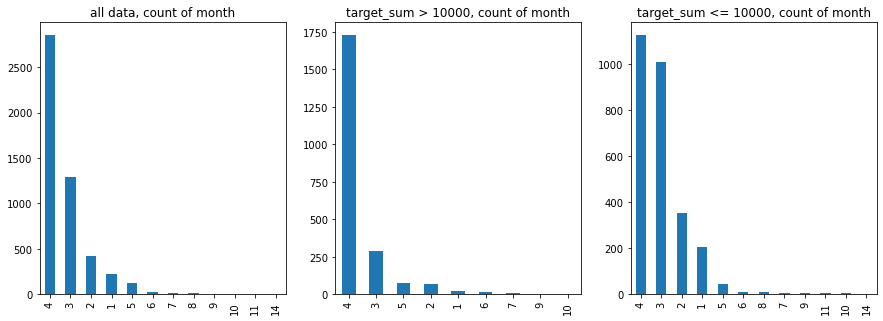

In [46]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
train.groupby('cl_id').count().year.value_counts().plot(kind='bar', title='all data, count of month', ax=ax[0])
train[train['target_sum'] > 10000].groupby('cl_id').count().year.value_counts().plot(kind='bar', title='target_sum > 10000, count of month', ax=ax[1])
train[train['target_sum'] <= 10000].groupby('cl_id').count().year.value_counts().plot(kind='bar', title='target_sum <= 10000, count of month', ax=ax[2])
plt.show()

# Вообще посмотрим, как себя ведут данные
В черновой версии больше, тут только что оставил в модель

9 ['target', '2017-7', '2017-6', '2017-5'] [0.0, 1559.0, 2206.09, 8600.0]


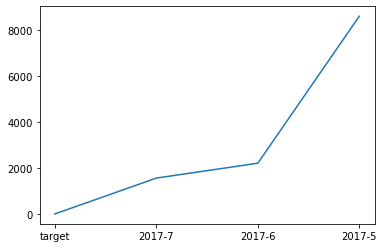

9 ['target', '2017-7', '2017-6', '2017-5'] [0.0, 1559.0, 2206.09, 8600.0]


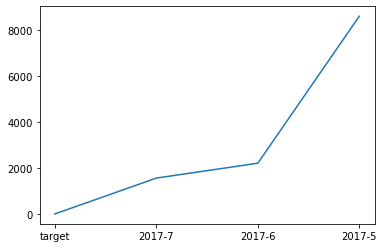

9 ['target', '2017-7', '2017-6', '2017-5'] [0.0, 1559.0, 2206.09, 8600.0]


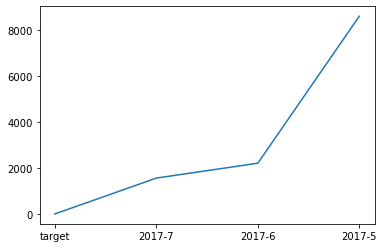

10 ['target', '2017-9', '2017-8', '2017-7'] [0.0, 61293.27, 95558.52000000002, 44104.32000000001]


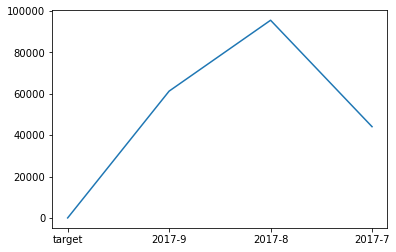

10 ['target', '2017-9', '2017-8', '2017-7'] [0.0, 61293.27, 95558.52000000002, 44104.32000000001]


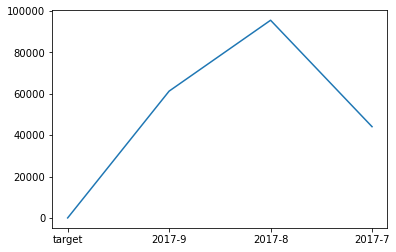

10 ['target', '2017-9', '2017-8', '2017-7'] [0.0, 61293.27, 95558.52000000002, 44104.32000000001]


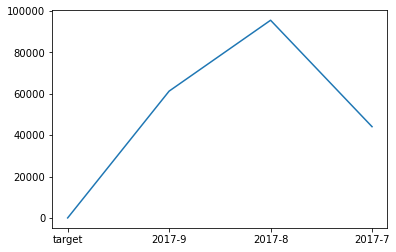

11 ['target', '2017-9', '2017-8', '2017-7', '2017-6'] [0.0, 6151.049999999999, 77543.74, 102395.59999999999, 59572.46]


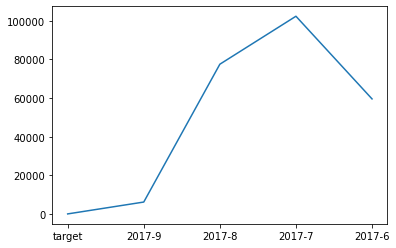

11 ['target', '2017-9', '2017-8', '2017-7', '2017-6'] [0.0, 6151.049999999999, 77543.74, 102395.59999999999, 59572.46]


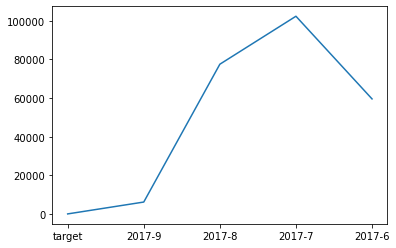

11 ['target', '2017-9', '2017-8', '2017-7', '2017-6'] [0.0, 6151.049999999999, 77543.74, 102395.59999999999, 59572.46]


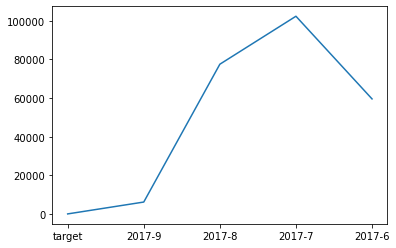

11 ['target', '2017-9', '2017-8', '2017-7', '2017-6'] [0.0, 6151.049999999999, 77543.74, 102395.59999999999, 59572.46]


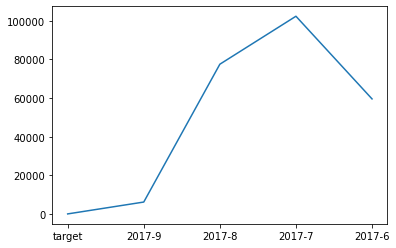

14 ['target', '2017-8', '2017-7', '2017-6', '2017-5'] [0.0, 31197.08, 72628.55, 10899.5, 144265.04]


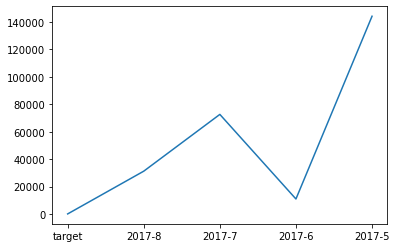

14 ['target', '2017-8', '2017-7', '2017-6', '2017-5'] [187776.76, 31197.08, 72628.55, 10899.5, 144265.04]


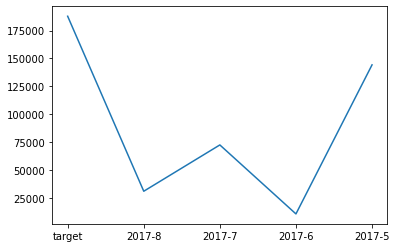

14 ['target', '2017-8', '2017-7', '2017-6', '2017-5'] [187776.76, 31197.08, 72628.55, 10899.5, 144265.04]


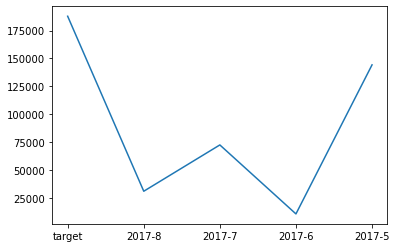

14 ['target', '2017-8', '2017-7', '2017-6', '2017-5'] [187776.76, 31197.08, 72628.55, 10899.5, 144265.04]


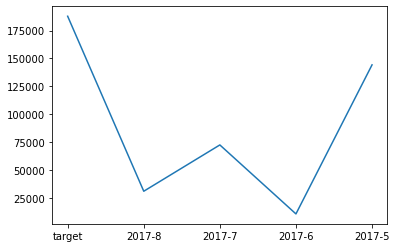

20 ['target', '2017-5', '2017-4', '2017-3'] [187776.76, 70379.64, 77301.36, 74627.09]


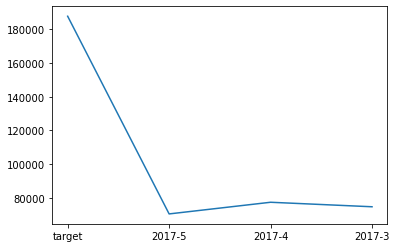

20 ['target', '2017-5', '2017-4', '2017-3'] [0.0, 70379.64, 77301.36, 74627.09]


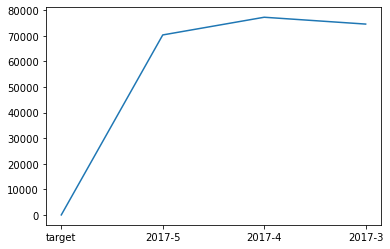

20 ['target', '2017-5', '2017-4', '2017-3'] [0.0, 70379.64, 77301.36, 74627.09]


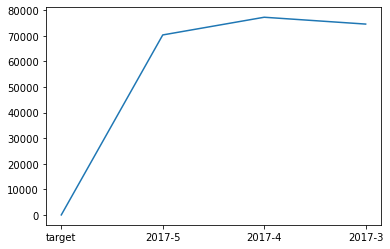

21 ['target', '2017-1', '2016-12', '2016-11'] [0.0, 75433.06, 70058.93, 74611.66]


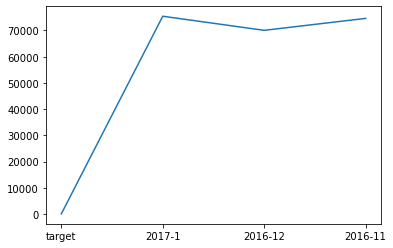

21 ['target', '2017-1', '2016-12', '2016-11'] [0.0, 75433.06, 70058.93, 74611.66]


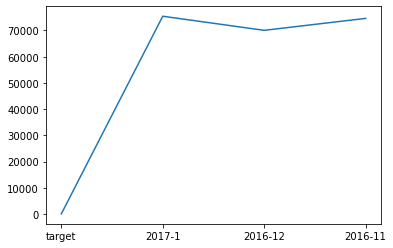

21 ['target', '2017-1', '2016-12', '2016-11'] [0.0, 75433.06, 70058.93, 74611.66]


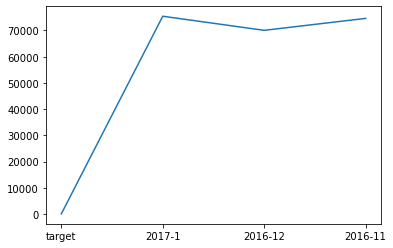

,cl_id,year,month,target_sum,sum_pos
0,21,2017,1,0.0,75433.06
1,21,2016,12,0.0,70058.93
2,21,2016,11,0.0,74611.66


In [52]:
for i in train.cl_id[10:30]:
    fig = plt.figure()
    x = list()
    y = list()
    temp_df = train[train['cl_id'] == i].reset_index(drop=True)
    x.append('target')
    y.append(j.target_sum)
    for ji in temp_df.index:
        j = temp_df.iloc[ji]
        x.append(str(int(j.year))+ '-' + str(int(j.month)))
        y.append(j.sum_pos)
    print(i,x,y)
    plt.plot(x,y)
    plt.show()
plt.close('all')  
temp_df

# Схема расчётов
Разделим клиентов на 2 группы:
1. С малой target_sum
2. С большой target_sum
Для каждой группы будет своя модель, чтобы эти группы не влияли друг на друга.
    Так как для группы 1 ошибка будет в границах их "малого" target_sum, т.е. её значение будет малым, взята классификация.
    Для группы 2 взята Non-negative least squares regression, что хоть и не позволяет отслеживать плавный спад целевой переменной, но убирает варианты, когда предсказания отрицательны. (а возможно из-за первого чистая нейронка показывала лучший R^2. но у двухстадийной модели распределение ошибок больше сдвинуто к минимальным)
    Возможно ещё нужен классификатор для высоких значение *target_sum*, а то модели самые высокие тестовые значения занижают

# Формирование выборки

In [54]:
columns_take = ['_1_sum_pos', '_2_sum_pos', '_3_sum_pos', '_4_sum_pos'] # от взятия 5й метрики качества незначительно меняются, а объём вычислений растёт
columns_drop = ['cl_id', 'target_sum']

train_tf['class'] = train_tf.apply(lambda row: 1 if row['target_sum'] > 10000 else 0, axis=1)
X = train_tf.drop(axis=1, labels=['cl_id', 'target_sum', 'class'])[columns_take]

# классификация
y_class = train_tf['class']
X_trainC, X_testC, y_trainC, y_testC = train_test_split(X, y_class, test_size=0.2, random_state=10)
# регрессия
y = train_tf['target_sum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Модель

## Сначала классификация на больше-меньше 10000

In [55]:
GBC = GradientBoostingClassifier(max_depth=2, random_state=0).fit(X_trainC, y_trainC)
GBC_pred = GBC.predict(X_testC)
accuracy_score(y_testC, GBC_pred)

0.756294058408862

In [56]:
# посмотрим на качество ещё так
up = 1
down = 0

res = pd.DataFrame(y_testC)
res['GBC'] = GBC_pred
res['delta_GBC'] = abs(res['class'] - res['GBC'])
print('True results from', len(y_testC))
print('GBC',len(res[(res['delta_GBC'] == down)]))

True results from 993
GBC 751


## Выбираем для тренировки регрессии то, что классифицируется как 1

In [57]:
X_train_cd = X_train.copy()
X_train_cd['classified'] = GBC.predict(X_train)
X_train_2nd = X_train_cd[X_train_cd['classified'] == 1].drop(axis=1, labels=['classified'])
y_train_2nd = y_train[y_train.index.isin(X_train_2nd.index)]

## Тренируем регрессию

In [58]:
nnls_sv_2nd = nnls(X_train_2nd, y_train_2nd)[0]

## Применяем модели

In [59]:
X_test_cd = X_test.copy()
GBC_pred = GBC.predict(X_test)
X_test_cd['classified'] = GBC_pred
nnls_pred_2nd = X_test.apply(lambda row: np.sum(row.to_numpy()*nnls_sv_2nd), axis=1)
X_test_cd['regression'] = nnls_pred_2nd
X_test_cd['predicted'] = X_test_cd.apply(lambda row: 0 if (row['classified']==0) else row['regression'], axis=1)
y_pred = X_test_cd['predicted']
r2_score(y_test, y_pred)

0.013651896228312532

In [60]:
explained_variance_score(y_test, y_pred)

0.016264834833696895

Text(0.5, 1.0, 'two-stage model difference')

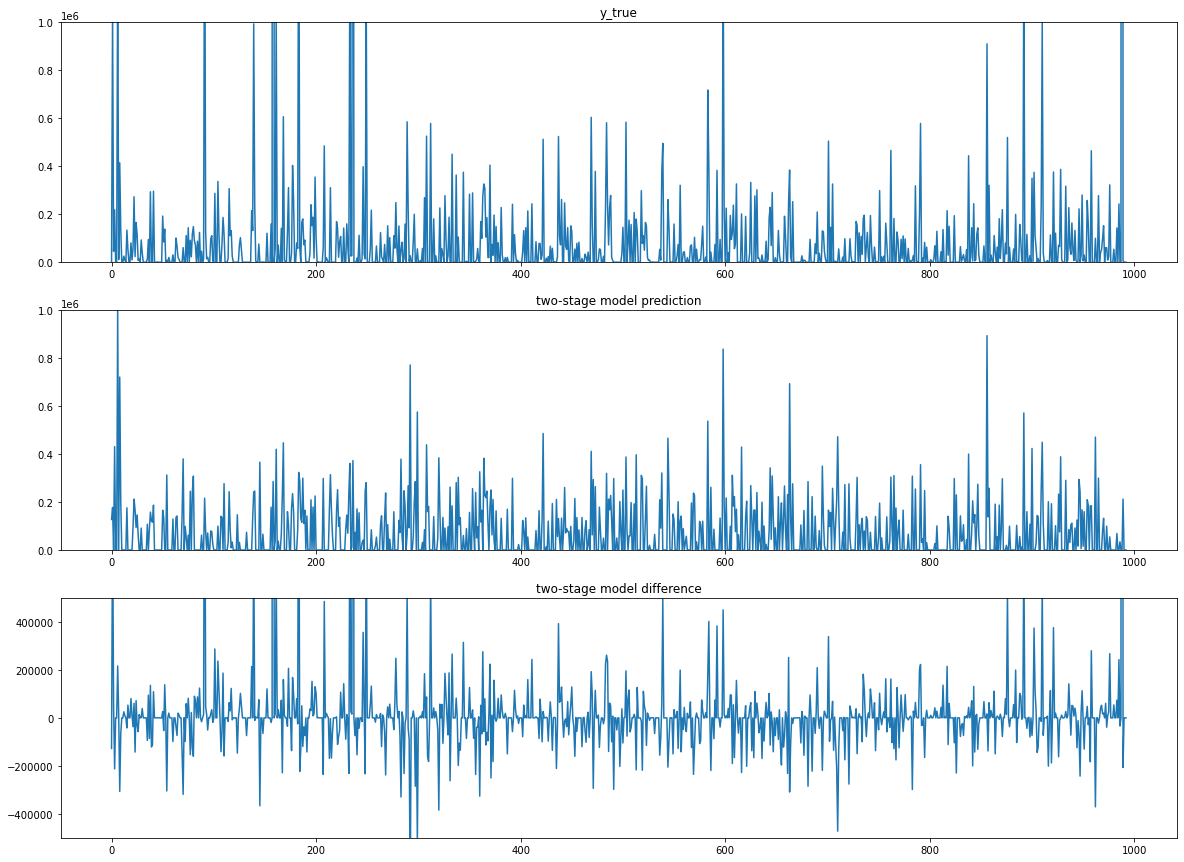

In [88]:
fig, ax = plt.subplots(3,1, figsize = (20,15))
ax[0].plot(np.arange(0,len(X_test)), y_test)
ax[1].plot(np.arange(0,len(X_test)), y_pred)
ax[2].plot(np.arange(0,len(X_test)), y_test.to_numpy() - y_pred)

ax[0].set_ylim(0,1000000)
ax[1].set_ylim(0,1000000)
ax[2].set_ylim(-500000,500000)


ax[0].set_title('y_true')
ax[1].set_title('two-stage model prediction')
ax[2].set_title('two-stage model difference')

Предсказано с ошибкой меньше, чем 5000 из 993
2stage 431


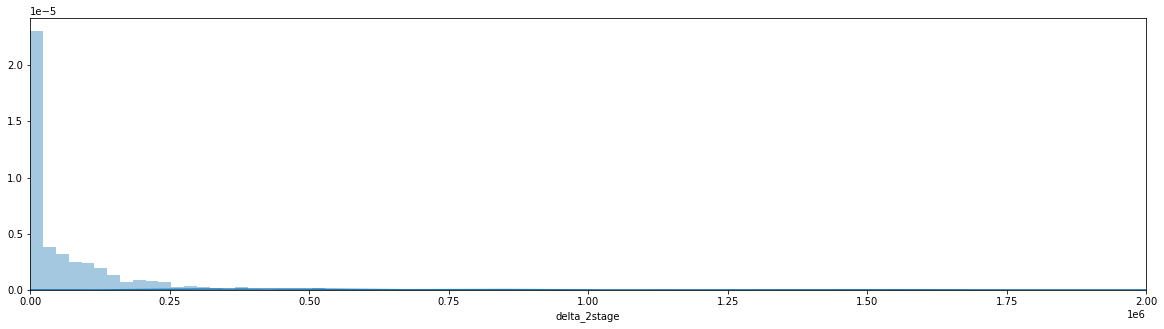

In [78]:
up = 400000
down = 5000

res = pd.DataFrame(y_test)
res['2stage'] = y_pred
res['delta_2stage'] = abs(res['target_sum'] - res['2stage'])
print('Предсказано с ошибкой меньше, чем', down, 'из', len(y_test))
print('2stage',len(res[(res['delta_2stage'] < down)]))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
sns.distplot(res['delta_2stage'], ax=ax, bins=1000)

ax.set_xlim(0,2000000)
plt.show()

#res[(res['delta_2stageR'] > up)][['target_sum', delta_2stage', '2stage']]
#res[(res['delta_2stage'] < down)][['target_sum', delta_2stage', '2stage']]

# Прогнозируем тестовую выборку

In [31]:
test.head(20)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS
5,01/03/2017,2,5977,NaN,810,24MAR17:00:00:00,833.00,POS
6,01/04/2017,2,5812,NaN,810,24APR17:00:00:00,196.00,POS
7,01/03/2017,2,6011,NaN,810,28MAR17:00:00:00,2000.00,WD_ATM_PARTNER
8,01/04/2017,2,5912,NaN,810,08APR17:00:00:00,831.30,POS
9,01/04/2017,2,5651,NaN,810,27APR17:00:00:00,998.00,POS


## Готовим выборку

In [55]:
test = test2.copy()
test = test[test['currency'] == 810]
test = MakeDateYearMonth(test, 'PERIOD')
group_list = ['cl_id', 'year', 'month']
ser_ts_sum = test[['cl_id', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).first().astype('float64')
ser_pos_amount_sum = groupbysum(test[test['trx_category'] == 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_pos')
'''ser_notpos_amount_sum = groupbysum(test[test['trx_category'] != 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_notpos')
ser_pos_count = groupbycount(test[test['trx_category'] == 'POS'][['cl_id', 'year', 'month']],
                       group_list,
                       'cl_id',
                       'count_pos')
ser_notpos_count = groupbycount(test[test['trx_category'] != 'POS'][['cl_id','year', 'month']],
                       group_list,
                       'cl_id',
                       'count_notpos')'''

test = DfLeftJoinSer(test.drop(axis=1, labels=['PERIOD','MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category']).drop_duplicates(),
                      #[ser_ts_sum, ser_pos_amount_sum, ser_notpos_amount_sum, ser_pos_count, ser_notpos_count],
                     [ser_ts_sum, ser_pos_amount_sum],
                      ['cl_id', 'year', 'month'])

test_tf = pd.DataFrame(columns=['cl_id'])
for i in test.cl_id.unique():
    test_tf = test_tf.append(test[test['cl_id'] == i][['cl_id']].iloc[0])
test_tf = test_tf.astype({'cl_id': 'int64'})
    
for mon in range(1,max_mon): # 14+1
    test_tf[f'_{mon}_sum_pos'] = np.NaN
    #test_tf[f'_{mon}_sum_notpos'] = np.NaN
    #test_tf[f'_{mon}_count_pos'] = np.NaN
    #test_tf[f'_{mon}_count_notpos'] = np.NaN
    
test = test.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False]) 
for ind in test_tf.index:
    mon = 1
    temp_id = test_tf.loc[ind].cl_id
    for ji in test[test['cl_id'] == temp_id].index:
        test_tf.loc[ind,f'_{mon}_sum_pos'] = test.loc[ji,'sum_pos']
        #test_tf.loc[ind,f'_{mon}_sum_notpos'] = test.loc[ji,'sum_notpos']
        #test_tf.loc[ind,f'_{mon}_count_pos'] = test.loc[ji,'count_pos']
        #test_tf.loc[ind,f'_{mon}_count_notpos'] = test.loc[ji,'count_notpos']
        mon+=1
test_tf.fillna(0, inplace=True)
test_tf.head()    

,cl_id,_1_sum_pos,_2_sum_pos,_3_sum_pos,_4_sum_pos,_5_sum_pos,_6_sum_pos,_7_sum_pos,_8_sum_pos,_9_sum_pos,_10_sum_pos,_11_sum_pos,_12_sum_pos,_13_sum_pos,_14_sum_pos
0,2,18153.80,75492.80,48191.96,47239.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,3,21351.15,44330.00,49964.94,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,4,749.00,190511.50,93676.26,104.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,6,344.00,49489.40,75271.66,64451.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702,7,31453.51,28330.34,22996.91,12017.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Прогоняем через модель

In [71]:
columns_take = ['_1_sum_pos', '_2_sum_pos', '_3_sum_pos', '_4_sum_pos']
test_X_mod = test_tf.drop(axis=1, labels=['cl_id'])[columns_take].copy()
test_X_mod_cd = test_X_mod.copy()
test_GBC_pred = GBC.predict(test_X_mod)
test_X_mod_cd['classified'] = test_GBC_pred
test_nnls_pred_2nd = test_X_mod.apply(lambda row: np.sum(row.to_numpy()*nnls_sv_2nd), axis=1)
test_X_mod_cd['regression'] = test_nnls_pred_2nd
test_X_mod_cd['predicted'] = test_X_mod_cd.apply(lambda row: 0 if (row['classified']==0) else row['regression'], axis=1)
test_y_pred = test_X_mod_cd['predicted']
test_y_pred

0         134391.884279
199            0.000000
295       139367.229679
453            0.000000
702        77699.454457
874       158735.557530
1072           0.000000
1088           0.000000
1198           0.000000
1210           0.000000
1220           0.000000
1378           0.000000
1384           0.000000
1408           0.000000
1467           0.000000
1471           0.000000
1580           0.000000
1586      126744.627211
1730           0.000000
1879           0.000000
1895       90027.791135
2008           0.000000
2063           0.000000
2131           0.000000
2143           0.000000
2155       94434.586874
2280      442714.438989
2315           0.000000
2326      169677.542379
2528       53318.973818
              ...      
514137         0.000000
514209         0.000000
514577         0.000000
514580         0.000000
515563         0.000000
515901         0.000000
515907         0.000000
515916         0.000000
515928         0.000000
515962    140096.973884
515974         0

In [78]:
test_res = pd.DataFrame(test_tf['cl_id'].copy())
test_res['target_sum'] = test_y_pred
test_res[['cl_id', 'target_sum']].to_csv('test_result.csv', index=False)
test_res.head()

,cl_id,target_sum
0,2,134391.884279
199,3,0.000000
295,4,139367.229679
453,6,0.000000
702,7,77699.454457
